In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Config')
from lablib import *

# Definizione funzioni

In [2]:
#Per la sezione di polarizzazione

def Malus_cmp_el(alfa, I0):
    return np.sqrt(I0)*(np.cos(alfa))

def Malus_onde_piane(alfa, I0):
    return I0*np.cos(alfa)**2

def Malus_onde_sferiche(alfa, I0, d):
    return (I0*(np.cos(alfa)/d)**2)

def Malus_combo(alfa, I0, A, B, C, D):
    return A*I0**C*np.cos(alfa)**2 + B*I0**D*np.cos(alfa)

def Malus_disperazione(alfa, I0, A, B, C):
    return A*I0*(np.cos(alfa))**2 + B*I0*(np.cos(alfa))**2 + C*I0*(np.cos(alfa))**2

#Sono da inserire di seguito le funzioni per fit dell'esperienza di polarizzazione
#Sono le funzioni al variare di theta e r 

#Per Brewster bisogna utilizzare un'iterpolazione parabolica
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

def parabola_shift(x, a, b):
    return -(x-b)**2 + a

#Per la sezione di interferenza dobbiamo scegliere due esperienza diverse. 
#Riporto comunque le funzioni per tutte e quattro

# #1 Per la sezione di interferenza con la doppia fenditura
# #massimi sono a: d*sin(theta) = n*lambda. Voglio ottenere theta
# def double_slit_max(n, d, l):
#     return np.arcsin(n*l/d)
    
# #minimi sono a: d*sin(theta) = (n/2)*lambda. Voglio ottenere theta
# def double_slit_min(n, d, l):
#     return np.arcsin(n*l/(2*d))


#2 Per la sezione di interferenza con specchio di LLoyd

#voglio ottenere lambda
def lloyd(h1, h2, d1):
    return 2*(np.sqrt(h2**2 + d1**2) - np.sqrt(h1**2 + d1**2))

# #3 Per la sezione di interferenza con cavità di Fabry-Perot

# #voglio ottenere distanza tra i due schermi semiriflettenti
# def fabry_perot(l, m):
#     return m*l/2

#4 Per la sezione di interferenza con Michelson

#voglio ottenere lambda. N è il numero di frange contate nello spostamento x dello specchio
def michelson(N, x):
    return 2*x/N

# Per la sezione di diffrazione alla Bragg

#Il massimo si ha per 2*d*sin(theta) = n*lambda. Voglio ottenere d
def braggs(l, n, theta):
    return l/(2*np.sin(theta))

# Import dati

# POLARIZZAZIONE

**NOTA!!!**\
ricordiamoci dell'errore sulle x

Le misure degli angoli sono prese in gradi \
Le misure di intensità sono prese in volt \
Sensibilità goniometro = 5 gradi \
Sensibilità amperometro = 0.01 volt  \
Oscillazione amperometro = 0.05 \
Errore sistematico nel goniometro: non è possibile fare in modo che siano sempre dritti \
Tentiamo d prendere le misure con sempre la stessa inclinazione. \
Distanza tra i ricevitori (da dritti) = 50cm

In [3]:
dati_polatizzazione = pd.read_excel("dati_pol.xlsx")
rad_malus = np.deg2rad(dati_polatizzazione["gradi"])
amp_malus = dati_polatizzazione["tensione"]
amp_malus_err = [0.05]*len(amp_malus)
dist_malus = .5

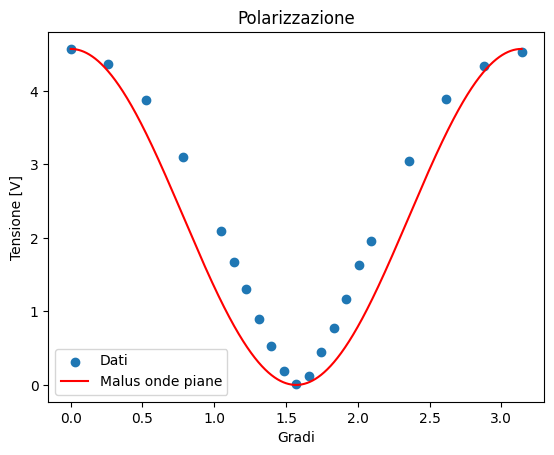

In [4]:
t1 = np.linspace(min(rad_malus), max(rad_malus), 100000)
plt.scatter(rad_malus, amp_malus, label="Dati", marker="o")
plt.plot(t1, Malus_onde_piane(t1, max(amp_malus)), label="Malus onde piane", color="red")
#plt.plot(t1, Malus_onde_sferiche(t1, max(amp_malus), dist_malus), label="Malus onde sferiche", color="green")
#plt.plot(t1, Malus_cmp_el(t1, max(amp_malus)), label="", color="blue")
plt.xlabel("Gradi")
plt.ylabel("Tensione [V]")
plt.title("Polarizzazione")
plt.legend()
plt.show()

In [5]:
#  #fit del modello combo

# def func(alfa, A, B, C):
#     return Malus_combo(alfa, max(amp), A, B, C)

# pars_malus, vals_malus, ers_malus, *other_malus = LS_fit(rad_malus, amp_malus, amp_malus_err, func, A=1, B=1, C=1)

In [6]:
#fit Malus disperazione

def func_disp(alfa, A, B, C):
    return Malus_disperazione(alfa, max(amp), A, B, C)

pars_malus_d, vals_malus_d, ers_malus_d, *other_malus_d = LS_fit(rad_malus, amp_malus, amp_malus_err, func_disp, A=1, B=1, C=1)

NameError: name 'amp' is not defined

# AMPIEZZA

## Rotazione

In [7]:
dati_rotazione = pd.read_excel("dati_rotazione.xlsx")
rad_rotaz_prec = np.deg2rad(dati_rotazione["gradi_precisi"])
amp2 = dati_rotazione["tensione_precisa"]
amp2_err = [0.05 for _ in amp2]

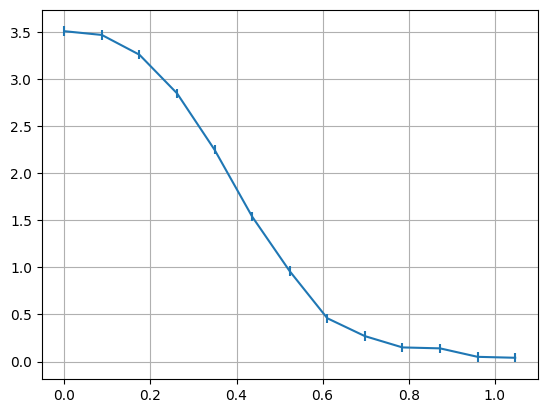

In [9]:
plt.errorbar(rad_rotaz_prec, amp2, amp2_err)
plt.grid()
plt.show()

## Distanza

Si può provare a fare i fit utilizzando solo i massimi o solo i minimi.

In [ ]:
dati_distanza = pd.read_excel("dati_distanza.xlsx")
dist = dati_distanza["distanza"][7:]
amp3 = dati_distanza["tensione"][7:]
amp3_err = [0.05 for _ in amp3]

In [ ]:
t3 = np.linspace(min(dist), max(dist), 100000)
plt.scatter(dist, amp3, marker=".")
plt.show()

In [ ]:
# tentativo di fit con modello 1/r

# ho provato un po' con questi modelli ma non funziona troppo
# def modello_1suR(x, A, T, omega, phi):
#     return (A*np.exp(-x/T)*np.cos(omega*x + phi))/x

# def modello_1suR_2(x, A, T, omega, phi):
#     return (A*np.exp(-x/T)*np.cos(omega*x + phi))/(x**2)

def mod_1suR(r, a, b):
    return a/r + b

pars1_1, vals1_1, ers1_1, *other1_1 = LS_fit(dist, amp3, amp3_err, mod_1suR, a=1, b=0)

In [ ]:
# modello 1/r^2

def mod_1suR2(r, a, b):
    return a/r**2 + b

pars1_2, vals1_2, ers1_2, *other1_2 = LS_fit(dist, amp3, amp3_err, mod_1suR2, a=1, b=0.5)

In [ ]:
# modello combinato

def mod_comb(r, a, b, c):
    return a/r + b/r**2 + c

pars1_3, vals1_3, ers1_3, *other1_3 = LS_fit(dist, amp3, amp3_err, mod_comb, a=1, b=1, c=0)

In [ ]:
# plot con le misure più fitte
# le misure oscillavano di meno

dist_prec = dati_distanza["distanza_precisa"].dropna()
amp3_prec = dati_distanza["tensione_precisa"].dropna()
amp3_prec_err = [0.02 for _ in amp3_prec]

In [ ]:
plt.errorbar(dist_prec, amp3_prec, amp3_prec_err, fmt=".r")
plt.grid()
plt.show()

proviamo a fittare con un modello combinato tra uno che va come 1/r o 1/r^2 e uno che va con un coseno smorzato

# ANGOLO DI BREWSTER

tensione senza polietilene $\approx$ 2.95 \
errore sulle x (gradi) = 2-3 

In [ ]:
dati_brewster_trasm = pd.read_excel("dati_brewster_trasm.xlsx")
gradi_br = dati_brewster_trasm["angolo"]
amp_br_tr_oriz = dati_brewster_trasm["tensione(oriz)"]
amp_br_tr_vert = dati_brewster_trasm["tensione(vert)"]
amp_br_tr_err = [0.03 for _ in amp_br_tr_vert]

## Trasmissione

In [ ]:
plt.errorbar(gradi_br, amp_br_tr_oriz, amp_br_tr_err)
plt.grid()
plt.show()

In [ ]:
dati_br_fit = amp_br_tr_oriz[8:11]
dati_br_fit_err = amp_br_tr_err[8:11]
gradi_br_fit = gradi_br[8:11]

pars2, vals2, ers2, *other2 = LS_fit(gradi_br_fit, dati_br_fit, dati_br_fit_err, parabola_shift, a=1, b=0)

per spiegare il picco iniziale, le onde vengono riflesse più volte, quindi leggiamo un segnale maggiore. \
per spiegare il picco finale, semplicemente parte delle onde raggiunge il ricevitore inimpedita, quindi non c'è perdita di segnale

In [ ]:
plt.errorbar(gradi_br, amp_br_tr_vert, amp_br_tr_err)
plt.grid()
plt.show()

## Riflessione

L'angolo lo abbiamo preso in base alla lastra di polietilene: ruotando la lastra, misuriamo l'angolo e spostiamo l'emettitore in modo da avere 180-2*$\theta$ (per la legge degli angoli o qualcosa) \
Ad esempio: se lo specchio è a 30°, l'emettitore sarà a 180°-60° = 120°

In [ ]:
# i dati non sono per nulla affidabili, se vogliamo fare sta parte sono da riprendere

# DIFFRAZIONE DI BRAGG

La condizione di Bragg si verifica quando la differenza di cammino ottico tra i riflessi dai vari piani del cristallo da luogo a interferenza costruttiva:

n $\lambda$ = 2dsin $\theta$

lunghezza d'onda tabulata = 2.85cm

Piano parallelo utilizzato famiglia (100) quindi n = 1



Giorno 2 abbiamo preso ogni 2 gradi il cubo e di conseguenza 4 gradi il ricevitore 
a partire da 90 fino a 160



In [73]:
dati_bragg = pd.read_excel("dati_bragg.xlsx")
rad_bragg = np.deg2rad(dati_bragg["angolo(giorno2)"])
amp_bragg = dati_bragg["tensione(giorno2)"]
amp_bragg_err = [0.03 for i in amp_bragg]

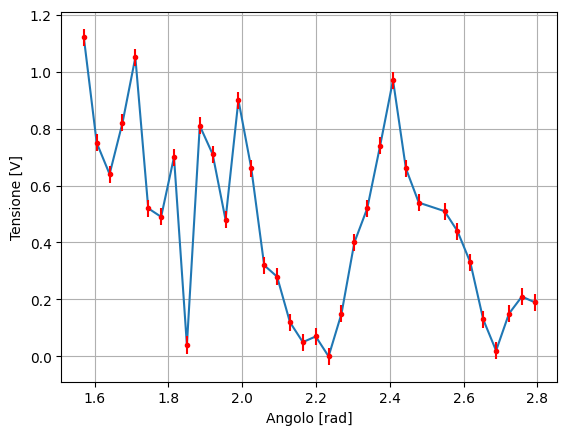

In [75]:
plt.plot(rad_bragg, amp_bragg)
plt.errorbar(rad_bragg, amp_bragg, amp_bragg_err, fmt=".r")
plt.xlabel("Angolo [rad]")
plt.ylabel("Tensione [V]")
plt.grid()
plt.show()
# I vari picchi strani del grafico rappresentano diffrazioni da vari piani oltre al nostro con indici 100

In [74]:
lambda_true = 2.85 #cm


# ho picco ogni volta che si veririca bragg 
# ovvero ogni volta che lambda = 2dsin(theta)
# il modello = lambda_true - 2dsin(theta)
# calcolo chi2 a mano sommando i quadrati delle diff
# d iniziale 1cm
def func(d):
    model = lambda_true - (2 * d * np.sin(theta))
    return np.sum(((amp_bragg - model)/ amp_bragg_err)**2)

m = Minuit(func, d = 1)
m.migrad()
d_fit = m.values["d"]
d_fit_err = m.errors["d"]
print(f"Stima della distanza d: ({d_fit:.4f} ± {d_fit_err:.4f}) cm")



Stima della distanza d: (1.4159 ± 0.0032) cm


# INTERFERENZA

## Michelson & Morley

**Posizioni iniziali** (distanze dal centro)
* emettitore = $26 \pm 0.3$ cm
* ricevitore = $28 \pm 0.3$ cm
* specchio b = $24.2 \pm 0.3$ cm
* specchio a (mobile) = $28.1 \pm 3$ cm --- segnato = 38.7 cm (sul metro)
* lunghezza del supporto = 4.5cm


In [ ]:
# minimi passati = 10
# errore sulle distanze = 0.2 cm
# errore sulle intensità = 0.02 V
x1 = 38.7
I1 = 0.82
x2 = 24.5
I2 = 0.87

x3 = 43.0
I3 = 1.1
x4 = 28.8
I4 = 0.83

x5 = 34.4
I5 = 0.83
x6 = 20.1
I6 = 0.86  

In [ ]:
# Calcolo delle lunghezze d'onda

mic_lambda_1 = (x1 - x2) / 10 * 2
mic_lambda_2 = (x3 - x4) / 10 * 2
mic_lambda_3 = (x5 - x6) / 10 * 2
#print(mic_lambda_1 , mic_lambda_2, mic_lambda_3)

mic_lambda_err = 0.2 
mic_sigma_lambda = np.sqrt(2 * (1/25)**2 * mic_lambda_err**2 ) # da formula della propagazione degli errori

mic_lambda_best = np.mean((mic_lambda_1, mic_lambda_2, mic_lambda_3))

print(f"Lambda best = {mic_lambda_best:.3g} +- {mic_sigma_lambda:.3g}")

In [ ]:
# test compatibilità

mic_lambda_comp = TestCompatibilita(mic_lambda_best, mic_sigma_lambda, 2.85, 0)
print(f"Test compatibilità lambda di Michelson: {mic_lambda_comp:.3g}")

In [ ]:
# relazione intensità non so bene cosa fare

# plt.scatter([x1,x2,x3,x4,x5,x6], [I1, I2, I3, I4, I5, I6])
# plt.show()

## Specchio di Lloyd

**Posizioni iniziali** (distanze dal centro)
* distanza specchio centro(shift) = $8 \pm 0.3$ cm
Per specchio di Lloyd abbiamo preso la distanza tra ricevitore ed emettitore reale, tra il punto di emissione e quello di ricezione.
* supporto-ricevitore = $5.5 \pm 0.3$ cm
* supporto-emettitore = $2.5 \pm 0.3$ cm
* Distanza12 emissione-ricezione = $100 \pm 1$ cm
* Distanza34 emissione-ricezione = $110 \pm 1$ cm


In [ ]:
#Misure prese con specchio sottile
#h1 = 10.4
#v1 = 1.74
#h2 = 16.7
#v2 = 1.74
#Le misure h sono prese in cm, le misure in v sono prese in volt
#Incertezza lunghezza: 0.2 cm, Incertezza intensità: 0.03 volt
h_err = 0.2
v_err = 0.03

# prima misurazione
d12 = 100 / 2
d12_err = 1

h1 = 9.9
v1 = 1.64
h2 = 16.9
v2 = 1.7

# seconda misurazione
d34 = 110 / 2
d34_err = 1

h3 = 10.9
v4 = 1.40
h4 = 17.2
v4 = 1.5


In [ ]:
# calcolo lambda con Lloyd, ricontrollare la formula

loy_lambda_1 = lloyd(h1, h2, d12)
loy_lambda_2 = lloyd(h3, h4, d34)

print(loy_lambda_1, loy_lambda_2)